In [38]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from imageio import imread
from torchvision. transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn as nn
import torch. nn.functional as F
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from collections import defaultdict


In [39]:
class CCPDataset(Dataset):
    """
    Dataset para segmentación semántica multiclase. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', y opcionalmente 'coords'
        patch_size: Tamaño del patch a extraer
        transforms: Lista [joint_transform, image_transform] donde:
            - joint_transform: se aplica a imagen y máscara (ej: flips, rotaciones)
            - image_transform: se aplica solo a imagen (ej: normalización)
        mode: 'train' (random crop), 'eval' (crop con coords), 'full' (imagen completa)
        class_dict_path: Ruta al CSV con columnas 'r', 'g', 'b' para mapeo de colores
    """

    def __init__(self, df, patch_size=224, transforms=None, mode='train', class_dict_path='clothes/class_dict.csv'):
        super(CCPDataset, self).__init__()
        self.df = df. reset_index(drop=True)
        self.ps = patch_size
        self. transforms = transforms
        self.mode = mode

        # Cargar diccionario de clases
        class_df = pd.read_csv(class_dict_path)
        
        # Crear mapping RGB -> class_id usando bit packing
        r = class_df['r'].to_numpy(dtype=np.uint32)
        g = class_df['g'].to_numpy(dtype=np.uint32)
        b = class_df['b'].to_numpy(dtype=np.uint32)

        keys = (r << 16) | (g << 8) | b

        self.color_to_class = dict(zip(keys. tolist(), range(len(keys))))
        self.num_classes = len(self.color_to_class)
        
        # Guardar nombres de clases si están disponibles
        if 'class_name' in class_df.columns:
            self.class_names = class_df['class_name']. tolist()
            if self.class_names[0] == 'null':
                self.class_names[0] = 'background'
        else:
            self.class_names = [f'class_{i}' for i in range(self.num_classes)]

    def mask_rgb_to_ids(self, mask):
        """
        Convierte máscara RGB a índices de clase usando bit packing.
        Colores no encontrados se mapean a clase 0 (background).
        """
        packed = (mask[...,0].astype(np.uint32) << 16) | \
                 (mask[...,1].astype(np.uint32) << 8)  | \
                  mask[...,2].astype(np.uint32)
        
        # Verificar colores desconocidos (opcional, comentar si no necesitas warnings)
        unique_packed = np.unique(packed)
        unknown = [p for p in unique_packed if p not in self.color_to_class]
        if unknown and self.mode == 'train':  # Solo warning en train para no saturar logs
            unknown_colors = [(p >> 16, (p >> 8) & 0xFF, p & 0xFF) for p in unknown[:3]]
            print(f"Warning: Found {len(unknown)} unknown colors (showing first 3): {unknown_colors}")
        
        mapped = np.vectorize(self.color_to_class.get)(packed, 0)
        return mapped. astype(np.int64)

    def __random_crop__(self, img, mask):
        """Extrae un crop aleatorio de tamaño self.ps"""
        H, W = img. shape[:2]
        
        if H < self.ps or W < self. ps:
            # Padding si la imagen es más pequeña que el patch
            pad_h = max(0, self.ps - H)
            pad_w = max(0, self.ps - W)
            img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            mask = np.pad(mask, ((0, pad_h), (0, pad_w), (0, 0)) if mask. ndim == 3 else ((0, pad_h), (0, pad_w)), mode='reflect')
            H, W = img.shape[:2]
        
        # Random top-left corner
        top = np.random.randint(0, H - self.ps + 1)
        left = np.random.randint(0, W - self.ps + 1)
        
        # Extract patch
        img_patch = img[top:top+self.ps, left:left+self.ps]
        mask_patch = mask[top:top+self.ps, left:left+self.ps]
        
        return img_patch, mask_patch

    def __getitem__(self, idx):
        r = self.df. iloc[idx]

        # Leer imagen y máscara
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Aplicar crop según el modo
        if self.mode == 'train':
            # Random crop para entrenamiento
            x, y = self.__random_crop__(x, y)
            
        elif self.mode == 'eval':
            # Crop con coordenadas específicas para evaluación
            if 'coords' in r and r.coords is not None:
                x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            else:
                # Si no hay coords, tomar centro
                H, W = x.shape[:2]
                top = max(0, (H - self.ps) // 2)
                left = max(0, (W - self.ps) // 2)
                x = x[top:top+self.ps, left:left+self.ps]
                y = y[top:top+self.ps, left:left+self.ps]
        
        # mode == 'full': no hacer crop, usar imagen completa

        # Convertir máscara RGB a IDs de clase
        if y.ndim == 3 and y.shape[2] == 3:
            y = self.mask_rgb_to_ids(y)
        else:
            y = y.astype(np.int64)

        # Convertir a PIL para aplicar transforms
        x = to_pil_image(x. astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')

        # Aplicar transformaciones
        if self. transforms:
            if isinstance(self.transforms, list):
                # Formato: [joint_transform, image_transform]
                if self.transforms[0] is not None:
                    x, y = self.transforms[0](x, y)
                if self.transforms[1] is not None:
                    x = self. transforms[1](x)
            else:
                # Solo image transform
                x = self.transforms(x)

        # Convertir a tensors
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(np.array(x)). permute(2, 0, 1).float() / 255.0
        
        y = torch.from_numpy(np.array(y, dtype=np.int64))

        return x, y

    def __len__(self):
        return self.df.shape[0]

    def __show_item__(self, x, y, denormalize=None):
        """
        Visualiza una muestra del dataset.
        
        Args:
            x: Tensor de imagen (C, H, W)
            y: Tensor de máscara (H, W)
            denormalize: Función para desnormalizar la imagen (opcional)
        """
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Desnormalizar imagen si es necesario
        if denormalize is not None:
            x_vis = denormalize(x)
        else:
            x_vis = x
        
        # Asegurar que x esté en rango [0, 1]
        x_vis = x_vis.permute(1, 2, 0).cpu().numpy()
        if x_vis.max() > 1.0:
            x_vis = x_vis / 255.0
        x_vis = np.clip(x_vis, 0, 1)

        y_vis = y.cpu().numpy()

        ax[0].imshow(x_vis)
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(y_vis, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[1]. set_title('Mask')
        ax[1].axis('off')

        ax[2].imshow(x_vis)
        ax[2].imshow(y_vis, alpha=0.5, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[2].set_title('Overlay')
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

In [40]:
class DataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule para segmentación semántica. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', 'set'
        class_dict_path: Ruta al CSV con clases
        bs: Batch size
        ps: Patch size
        num_workers: Número de workers para DataLoader
    """
    
    def __init__(self, df, class_dict_path='clothes/class_dict.csv', bs=16, ps=256, num_workers=8):
        super().__init__()
        self.df = df
        self.class_dict_path = class_dict_path
        self.bs = bs
        self.ps = ps
        self. num_workers = num_workers
        
        # Cargar número de clases
        class_df = pd.read_csv(class_dict_path)
        self.num_classes = len(class_df)

    def setup(self, stage=None):
        """Preparar datasets con transforms apropiados"""
        
        # Transforms para normalización (solo imagen)
        normalize_transform = T.Compose([
            T.ToTensor(),
            T. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Para train: sin joint transforms (podrías agregar data augmentation aquí)
        train_transforms = [None, normalize_transform]
        
        # Para val/test: solo normalización
        eval_transforms = [None, normalize_transform]
        
        # Crear datasets
        self.train_ds = CCPDataset(
            df=self.df. query('set == "train"'). reset_index(drop=True),
            patch_size=self. ps,
            transforms=train_transforms,
            mode='train',
            class_dict_path=self.class_dict_path
        )
        
        self. valid_ds = CCPDataset(
            df=self.df. query('set == "valid"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='train',  # También random crop en validación
            class_dict_path=self.class_dict_path
        )
        
        self.test_ds = CCPDataset(
            df=self. df.query('set == "test"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='full',  # Imagen completa para test
            class_dict_path=self.class_dict_path
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.bs,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.bs,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=1,  # Batch size 1 para imágenes completas
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    @staticmethod
    def patch_origins(h, w, ps, overlap=2):
        """
        Genera coordenadas de origen para patches con overlap.
        
        Args:
            h, w: Alto y ancho de la imagen
            ps: Tamaño del patch
            overlap: Factor de overlap (overlap=2 significa 50% de overlap)
        
        Returns:
            Array de coordenadas (x, y) de origen de cada patch
        """
        stride = ps // overlap
        origins = []
        
        for x in range(0, h - ps + 1, stride):
            for y in range(0, w - ps + 1, stride):
                origins.append([x, y])
        
        # Agregar bordes si no están cubiertos
        if (h - ps) % stride != 0:
            for y in range(0, w - ps + 1, stride):
                origins.append([h - ps, y])
        
        if (w - ps) % stride != 0:
            for x in range(0, h - ps + 1, stride):
                origins.append([x, w - ps])
        
        # Esquina inferior derecha
        if (h - ps) % stride != 0 and (w - ps) % stride != 0:
            origins. append([h - ps, w - ps])
        
        return np.array(origins)

In [41]:
class SegmentationModel(pl.LightningModule):
    """
    PyTorch Lightning Module para segmentación semántica multiclase.
    
    Args:
        num_classes: Número de clases de segmentación
        encoder_name: Nombre del encoder (ej: 'efficientnet-b3', 'efficientnet-b3', 'efficientnet-b0')
        encoder_weights: Pesos pre-entrenados (ej: 'imagenet')
        learning_rate: Learning rate para el optimizador
        architecture: Arquitectura del modelo ('unet', 'deeplabv3', 'fpn', 'pspnet')
    """
    
    def __init__(self, num_classes, encoder_name='efficientnet-b3', encoder_weights='imagenet', 
                 learning_rate=1e-3, architecture='unet'):
        super().__init__()
        self.save_hyperparameters()
        
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.architecture = architecture
        self.loss_fn = smp.losses.DiceLoss(
            mode='multiclass', 
            from_logits=True,
            log_loss=False
        )
        self.ce_loss = nn.CrossEntropyLoss()
        
        # Crear modelo según arquitectura
        if architecture == 'unet':
            self.model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'deeplabv3':
            self.model = smp.DeepLabV3(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'fpn':
            self.model = smp.FPN(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'pspnet':
            self.model = smp.PSPNet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        else:
            raise ValueError(f"Architecture {architecture} not supported. Choose from: 'unet', 'deeplabv3', 'fpn', 'pspnet'")
        
        # Métricas - IoU y Dice (F1)
        self.train_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.val_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.train_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None)
        self.val_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None)
        
        self.train_dice = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.val_dice = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        # Métricas acumuladas por época
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss_dice = self.loss_fn(logits, y)
        loss_ce = self.ce_loss(logits, y)
        loss = loss_dice + loss_ce
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)
        
        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['acc'] += acc.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss_dice = self.loss_fn(logits, y)
        loss_ce = self.ce_loss(logits, y)
        loss = loss_dice + loss_ce
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)
        
        # Actualizar IoU per-class
        self.val_iou_per_class.update(preds, y)
        
        # Logging
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['acc'] += acc.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self):
        if self.training_step_outputs['steps'] > 0:
            avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
            avg_acc = self.training_step_outputs['acc'] / self.training_step_outputs['steps']
            
            # Obtener métricas finales
            train_iou = self.train_iou.compute()
            train_dice = self.train_dice.compute()
            train_iou_per_class = self.train_iou_per_class.compute()
            
            print(f"\nEpoch {self.current_epoch} - Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(train_iou_per_class):
                self.log(f'train_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.train_iou.reset()
            self.train_dice.reset()
            self.train_iou_per_class.reset()
            
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        if self.validation_step_outputs['steps'] > 0:
            avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
            avg_acc = self.validation_step_outputs['acc'] / self.validation_step_outputs['steps']
            
            # Obtener métricas finales
            val_iou = self.val_iou.compute()
            val_dice = self.val_dice.compute()
            val_iou_per_class = self.val_iou_per_class.compute()
            
            print(f"Epoch {self.current_epoch} - Val Loss: {avg_loss:.4f}, Val Acc: {avg_acc:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(val_iou_per_class):
                self.log(f'val_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.val_iou.reset()
            self.val_dice.reset()
            self.val_iou_per_class.reset()
            
        self.validation_step_outputs.clear()

Total images: 1004
set
train    700
test     154
valid    150
Name: count, dtype: int64
                       image_path                       mask_path   set
0  ./clothes/test/images/0851.jpg  ./clothes/test/labels/0851.png  test
1  ./clothes/test/images/0852.jpg  ./clothes/test/labels/0852.png  test
2  ./clothes/test/images/0853.jpg  ./clothes/test/labels/0853.png  test
3  ./clothes/test/images/0854.jpg  ./clothes/test/labels/0854.png  test
4  ./clothes/test/images/0855.jpg  ./clothes/test/labels/0855.png  test

Dataset Classes:
 0. background           - RGB: [69, 6, 90]
 1. accessories          - RGB: [70, 12, 95]
 2. bag                  - RGB: [71, 18, 101]
 3. belt                 - RGB: [72, 25, 107]
 4. blazer               - RGB: [72, 30, 112]
 5. blouse               - RGB: [72, 35, 116]
 6. bodysuit             - RGB: [71, 40, 120]
 7. boots                - RGB: [70, 47, 124]
 8. bra                  - RGB: [69, 52, 127]
 9. bracelet             - RGB: [68, 57, 130]
10. c

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


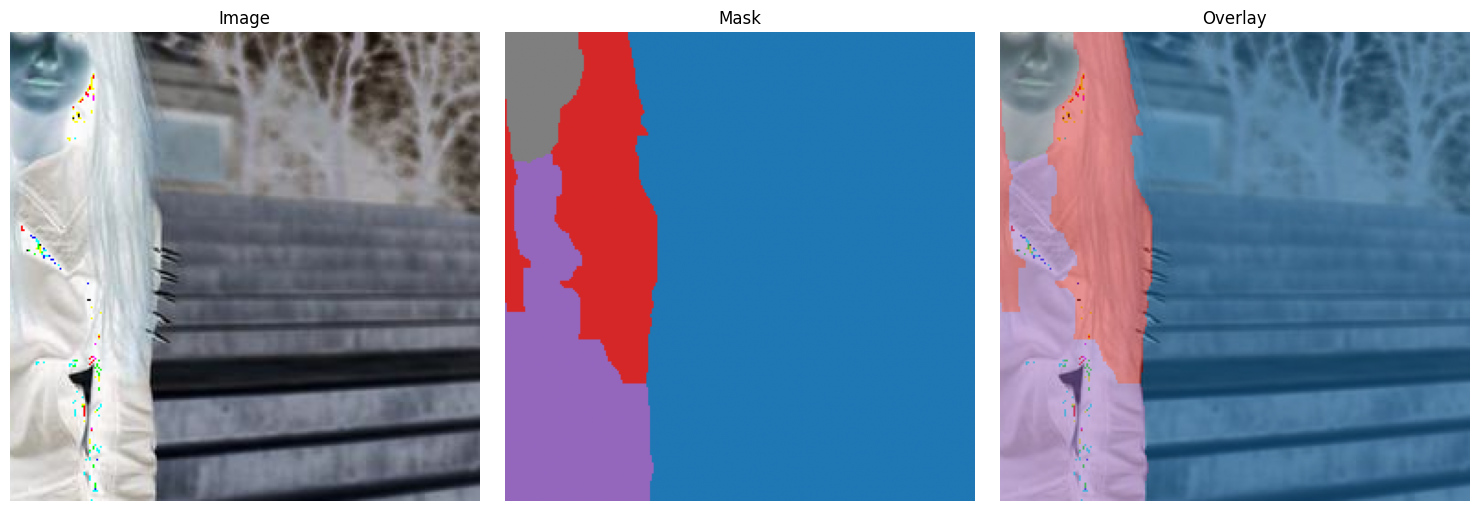


Sample 1:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 2, 13, 17, 38, 41, 48]


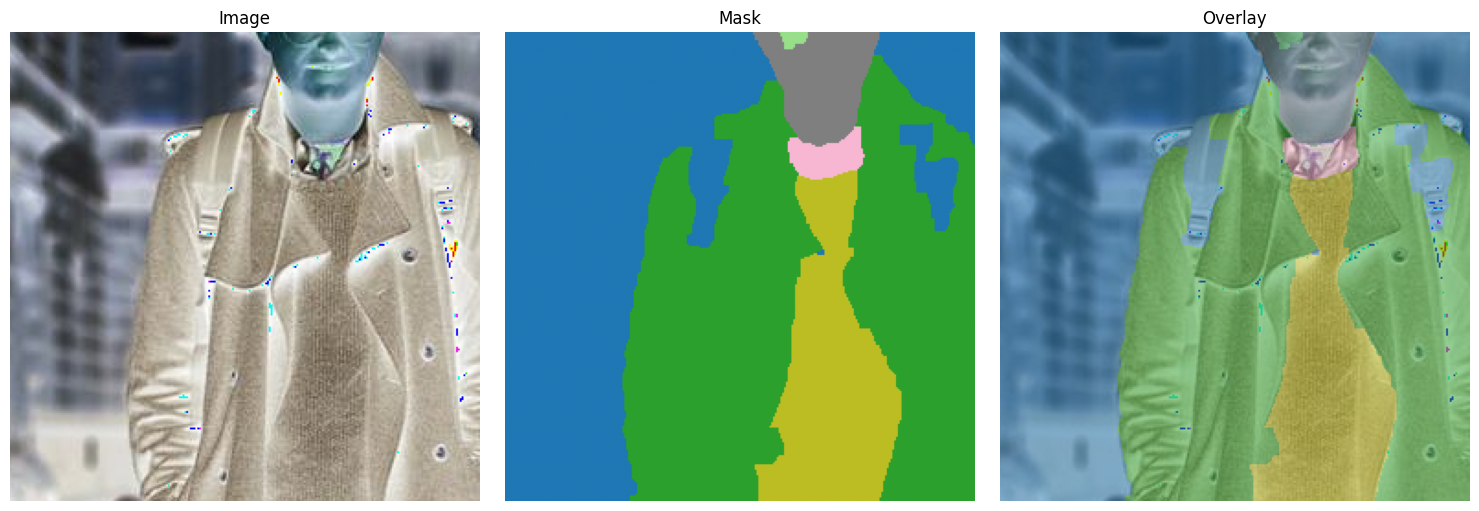


Sample 2:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 14, 19, 41, 47, 55]


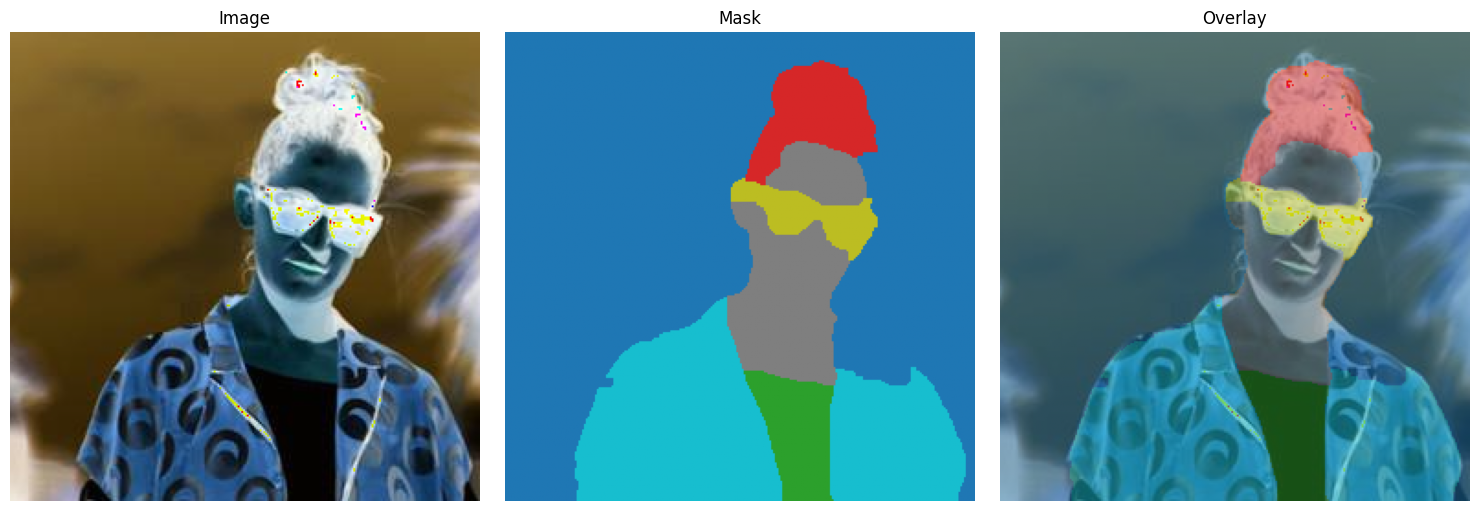

In [42]:
import glob
import pandas as pd
import os

# ============================================
# 1.  PREPARAR DATOS
# ============================================

DATA_DIR = 'clothes'

# Cargar imágenes
images = glob.glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df. image_path.apply(lambda x: x.replace('/images/', '/labels/'). replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x: x.split('/')[2])

print(f"Total images: {len(df)}")
print(df['set'].value_counts())
print(df. head())

# Cargar diccionario de clases
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_names = class_dict['class_name'].tolist()
class_names[0] = 'background'  # Renombrar 'null' a 'background'
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('\n' + '='*50)
print('Dataset Classes:')
print('='*50)
for i, (name, rgb) in enumerate(zip(class_names, class_rgb_values)):
    print(f"{i:2d}. {name:20s} - RGB: {rgb}")
print('='*50 + '\n')

# ============================================
# 2. CREAR DATAMODULE
# ============================================

dm = DataModule(
    df=df,
    class_dict_path=os.path.join(DATA_DIR, 'class_dict.csv'),
    bs=16,
    ps=256,
    num_workers=4  # Ajusta según tu CPU
)

dm.setup()

print(f"Train samples: {len(dm.train_ds)}")
print(f"Valid samples: {len(dm. valid_ds)}")
print(f"Test samples: {len(dm.test_ds)}")
print(f"Number of classes: {dm.num_classes}")

# ============================================
# 3.  VISUALIZAR MUESTRAS
# ============================================
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Desnormaliza una imagen normalizada con mean y std de ImageNet.
    
    Args:
        image (Tensor): Imagen normalizada (C, H, W)
        mean (list): Valores de media usados en normalización
        std (list): Valores de desviación estándar usados en normalización
    
    Returns:
        Tensor: Imagen desnormalizada en rango [0, 1]
    """
    # Asegurar que sea tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    
    # Crear tensores de mean y std con la forma correcta
    mean = torch.tensor(mean, dtype=image.dtype, device=image.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=image.dtype, device=image.device).view(3, 1, 1)
    
    # Desnormalizar: x = (x * std) + mean
    image = image * std + mean
    
    # Asegurar que esté en rango [0, 1]
    image = torch.clamp(image, 0, 1)
    
    return image

# Visualizar algunas muestras de entrenamiento
for i in range(3):
    x, y = dm.train_ds[i]
    print(f"\nSample {i}:")
    print(f"Image shape: {x.shape}")
    print(f"Mask shape: {y.shape}")
    print(f"Unique classes in mask: {torch.unique(y). tolist()}")

    # Asegurarse de que x sea un tensor de PyTorch antes de llamar a permute
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    dm.train_ds.__show_item__(x, y, denormalize=denormalize_image)

In [43]:
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [44]:
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Configuration
ENCODER_NAME = 'efficientnet-b3'
LEARNING_RATE = 1e-3
MAX_EPOCHS = 30
BATCH_SIZE = 32
PATCH_SIZE = 224
CLASS_DICT_PATH = 'clothes/class_dict.csv'
NUM_WORKERS = 4

# Architectures to train
ARCHITECTURES = ['unet', 'deeplabv3', 'fpn', 'pspnet']

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Load the data module once to get num_classes
data_module = DataModule(df, class_dict_path=CLASS_DICT_PATH, bs=BATCH_SIZE, ps=PATCH_SIZE, num_workers=NUM_WORKERS)
data_module.setup()
NUM_CLASSES = data_module.num_classes

# Train each architecture
for architecture in ARCHITECTURES:
    print(f"\n{'='*60}")
    print(f"Training {architecture.upper()}")
    print(f"{'='*60}\n")
    
    # Instantiate the SegmentationModel
    model = SegmentationModel(
        num_classes=NUM_CLASSES,
        encoder_name=ENCODER_NAME,
        encoder_weights='imagenet',
        learning_rate=LEARNING_RATE,
        architecture=architecture
    )
    
    # Define a CSV logger with folder structure
    csv_logger = CSVLogger(
        save_dir='experiments',
        name=architecture,
        version=None
    )
    
    # Define checkpoint callbacks
    checkpoint_val_loss = ModelCheckpoint(
        dirpath=f'experiments/{architecture}/checkpoints',
        filename='best_val_loss-{epoch:02d}-{val_loss:.4f}',
        monitor='val_loss',
        mode='min',
        save_top_k=1,
        verbose=True
    )
    
    checkpoint_val_iou = ModelCheckpoint(
        dirpath=f'experiments/{architecture}/checkpoints',
        filename='best_val_iou-{epoch:02d}-{val_iou:.4f}',
        monitor='val_iou',
        mode='max',
        save_top_k=1,
        verbose=True
    )
    
    checkpoint_last = ModelCheckpoint(
        dirpath=f'experiments/{architecture}/checkpoints',
        filename='last-{epoch:02d}',
        save_last=True,
        verbose=True
    )
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=csv_logger,
        callbacks=[checkpoint_val_loss, checkpoint_val_iou, checkpoint_last],
        devices=1,
        deterministic=False,  # Use 'warn' instead of True for better compatibility
        log_every_n_steps=1
    )
    
    # Recreate data module for each architecture to ensure clean state
    arch_data_module = DataModule(df, class_dict_path=CLASS_DICT_PATH, bs=BATCH_SIZE, ps=PATCH_SIZE, num_workers=NUM_WORKERS)
    arch_data_module.setup()
    
    # Train the model
    trainer.fit(model, arch_data_module)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{architecture.upper()} training completed!")
    print(f"Best model (val_loss): {checkpoint_val_loss.best_model_path}")
    print(f"Best model (val_iou): {checkpoint_val_iou.best_model_path}")
    print(f"{'='*60}\n")

print("\n" + "="*60)
print("ALL ARCHITECTURES TRAINED SUCCESSFULLY!")
print("="*60)

Seed set to 42



Training UNET



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | Unet                   | 13.2 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 5.8584, Val Acc: 0.0011, Val IoU: 0.0006, Val Dice: 0.0012


/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWar

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 2.30736 (best 2.30736), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=00-val_loss=2.3074.ckpt' as top 1


Epoch 0 - Val Loss: 2.3038, Val Acc: 0.5803, Val IoU: 0.0380, Val Dice: 0.0471

Epoch 0 - Train Loss: 3.4695, Train Acc: 0.4200, Train IoU: 0.0186, Train Dice: 0.0271


Epoch 0, global step 22: 'val_iou' reached 0.05168 (best 0.05168), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=00-val_iou=0.0517.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.96182 (best 1.96182), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=01-val_loss=1.9618.ckpt' as top 1


Epoch 1 - Val Loss: 1.9504, Val Acc: 0.6268, Val IoU: 0.0332, Val Dice: 0.0417

Epoch 1 - Train Loss: 2.1191, Train Acc: 0.6264, Train IoU: 0.0312, Train Dice: 0.0393


Epoch 1, global step 44: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.82320 (best 1.82320), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=02-val_loss=1.8232.ckpt' as top 1


Epoch 2 - Val Loss: 1.8193, Val Acc: 0.6109, Val IoU: 0.0383, Val Dice: 0.0479

Epoch 2 - Train Loss: 1.8833, Train Acc: 0.6333, Train IoU: 0.0303, Train Dice: 0.0376


Epoch 2, global step 66: 'val_iou' reached 0.05826 (best 0.05826), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=02-val_iou=0.0583.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' reached 1.77071 (best 1.77071), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=03-val_loss=1.7707.ckpt' as top 1


Epoch 3 - Val Loss: 1.7540, Val Acc: 0.6221, Val IoU: 0.0366, Val Dice: 0.0456

Epoch 3 - Train Loss: 1.7687, Train Acc: 0.6583, Train IoU: 0.0336, Train Dice: 0.0413


Epoch 3, global step 88: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' reached 1.62097 (best 1.62097), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=04-val_loss=1.6210.ckpt' as top 1


Epoch 4 - Val Loss: 1.6312, Val Acc: 0.6652, Val IoU: 0.0406, Val Dice: 0.0527

Epoch 4 - Train Loss: 1.7497, Train Acc: 0.6512, Train IoU: 0.0359, Train Dice: 0.0449


Epoch 4, global step 110: 'val_iou' reached 0.06568 (best 0.06568), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=04-val_iou=0.0657.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1
Epoch 5, global step 132: 'val_iou' reached 0.07066 (best 0.07066), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=05-val_iou=0.0707.ckpt' as top 1


Epoch 5 - Val Loss: 1.6443, Val Acc: 0.6670, Val IoU: 0.0458, Val Dice: 0.0586

Epoch 5 - Train Loss: 1.7030, Train Acc: 0.6607, Train IoU: 0.0406, Train Dice: 0.0519


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' was not in top 1
Epoch 6, global step 154: 'val_iou' reached 0.07443 (best 0.07443), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=06-val_iou=0.0744.ckpt' as top 1


Epoch 6 - Val Loss: 1.7340, Val Acc: 0.6422, Val IoU: 0.0491, Val Dice: 0.0635

Epoch 6 - Train Loss: 1.6792, Train Acc: 0.6583, Train IoU: 0.0412, Train Dice: 0.0525


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' reached 1.57448 (best 1.57448), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=07-val_loss=1.5745.ckpt' as top 1


Epoch 7 - Val Loss: 1.5698, Val Acc: 0.6595, Val IoU: 0.0551, Val Dice: 0.0706

Epoch 7 - Train Loss: 1.6672, Train Acc: 0.6684, Train IoU: 0.0465, Train Dice: 0.0604


Epoch 7, global step 176: 'val_iou' reached 0.08232 (best 0.08232), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=07-val_iou=0.0823.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1
Epoch 8, global step 198: 'val_iou' was not in top 1


Epoch 8 - Val Loss: 1.6979, Val Acc: 0.6324, Val IoU: 0.0561, Val Dice: 0.0735

Epoch 8 - Train Loss: 1.6668, Train Acc: 0.6645, Train IoU: 0.0468, Train Dice: 0.0613


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1
Epoch 9, global step 220: 'val_iou' was not in top 1


Epoch 9 - Val Loss: 1.6627, Val Acc: 0.6668, Val IoU: 0.0519, Val Dice: 0.0675

Epoch 9 - Train Loss: 1.6039, Train Acc: 0.6898, Train IoU: 0.0524, Train Dice: 0.0691


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1
Epoch 10, global step 242: 'val_iou' reached 0.09100 (best 0.09100), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=10-val_iou=0.0910.ckpt' as top 1


Epoch 10 - Val Loss: 1.6338, Val Acc: 0.6603, Val IoU: 0.0624, Val Dice: 0.0811

Epoch 10 - Train Loss: 1.6600, Train Acc: 0.6665, Train IoU: 0.0501, Train Dice: 0.0659


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' reached 1.54087 (best 1.54087), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=11-val_loss=1.5409.ckpt' as top 1


Epoch 11 - Val Loss: 1.5284, Val Acc: 0.6839, Val IoU: 0.0733, Val Dice: 0.0994

Epoch 11 - Train Loss: 1.5575, Train Acc: 0.6814, Train IoU: 0.0552, Train Dice: 0.0742


Epoch 11, global step 264: 'val_iou' reached 0.09721 (best 0.09721), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=11-val_iou=0.0972.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' reached 1.52415 (best 1.52415), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=12-val_loss=1.5242.ckpt' as top 1


Epoch 12 - Val Loss: 1.5243, Val Acc: 0.6905, Val IoU: 0.0693, Val Dice: 0.0934

Epoch 12 - Train Loss: 1.5162, Train Acc: 0.7018, Train IoU: 0.0590, Train Dice: 0.0791


Epoch 12, global step 286: 'val_iou' reached 0.09829 (best 0.09829), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=12-val_iou=0.0983.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1
Epoch 13, global step 308: 'val_iou' reached 0.10998 (best 0.10998), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=13-val_iou=0.1100.ckpt' as top 1


Epoch 13 - Val Loss: 1.5477, Val Acc: 0.6778, Val IoU: 0.0828, Val Dice: 0.1090

Epoch 13 - Train Loss: 1.4993, Train Acc: 0.7086, Train IoU: 0.0643, Train Dice: 0.0871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' reached 1.49896 (best 1.49896), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=14-val_loss=1.4990.ckpt' as top 1


Epoch 14 - Val Loss: 1.4963, Val Acc: 0.6910, Val IoU: 0.0720, Val Dice: 0.0954

Epoch 14 - Train Loss: 1.5136, Train Acc: 0.6961, Train IoU: 0.0627, Train Dice: 0.0833


Epoch 14, global step 330: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' reached 1.39511 (best 1.39511), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=15-val_loss=1.3951.ckpt' as top 1


Epoch 15 - Val Loss: 1.3848, Val Acc: 0.7290, Val IoU: 0.0785, Val Dice: 0.1036

Epoch 15 - Train Loss: 1.4699, Train Acc: 0.7036, Train IoU: 0.0696, Train Dice: 0.0936


Epoch 15, global step 352: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1
Epoch 16, global step 374: 'val_iou' reached 0.12222 (best 0.12222), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=16-val_iou=0.1222.ckpt' as top 1


Epoch 16 - Val Loss: 1.4381, Val Acc: 0.6972, Val IoU: 0.0884, Val Dice: 0.1159

Epoch 16 - Train Loss: 1.4746, Train Acc: 0.7072, Train IoU: 0.0702, Train Dice: 0.0942


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1
Epoch 17, global step 396: 'val_iou' reached 0.13234 (best 0.13234), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=17-val_iou=0.1323.ckpt' as top 1


Epoch 17 - Val Loss: 1.4453, Val Acc: 0.6984, Val IoU: 0.0906, Val Dice: 0.1228

Epoch 17 - Train Loss: 1.4446, Train Acc: 0.7078, Train IoU: 0.0807, Train Dice: 0.1085


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' was not in top 1
Epoch 18, global step 418: 'val_iou' was not in top 1


Epoch 18 - Val Loss: 1.4298, Val Acc: 0.7203, Val IoU: 0.0959, Val Dice: 0.1293

Epoch 18 - Train Loss: 1.3822, Train Acc: 0.7377, Train IoU: 0.0833, Train Dice: 0.1128


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' reached 1.38948 (best 1.38948), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=19-val_loss=1.3895.ckpt' as top 1


Epoch 19 - Val Loss: 1.3936, Val Acc: 0.7290, Val IoU: 0.1005, Val Dice: 0.1356

Epoch 19 - Train Loss: 1.4091, Train Acc: 0.7285, Train IoU: 0.0896, Train Dice: 0.1204


Epoch 19, global step 440: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1
Epoch 20, global step 462: 'val_iou' was not in top 1


Epoch 20 - Val Loss: 1.4615, Val Acc: 0.6989, Val IoU: 0.0910, Val Dice: 0.1220

Epoch 20 - Train Loss: 1.3424, Train Acc: 0.7455, Train IoU: 0.0876, Train Dice: 0.1174


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1
Epoch 21, global step 484: 'val_iou' reached 0.14380 (best 0.14380), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=21-val_iou=0.1438.ckpt' as top 1


Epoch 21 - Val Loss: 1.4334, Val Acc: 0.7209, Val IoU: 0.1041, Val Dice: 0.1375

Epoch 21 - Train Loss: 1.3505, Train Acc: 0.7328, Train IoU: 0.0897, Train Dice: 0.1202


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1
Epoch 22, global step 506: 'val_iou' was not in top 1


Epoch 22 - Val Loss: 1.3986, Val Acc: 0.7146, Val IoU: 0.1017, Val Dice: 0.1365

Epoch 22 - Train Loss: 1.3521, Train Acc: 0.7323, Train IoU: 0.0912, Train Dice: 0.1220


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' reached 1.35809 (best 1.35809), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=23-val_loss=1.3581.ckpt' as top 1


Epoch 23 - Val Loss: 1.3549, Val Acc: 0.7258, Val IoU: 0.1241, Val Dice: 0.1635

Epoch 23 - Train Loss: 1.3782, Train Acc: 0.7349, Train IoU: 0.0921, Train Dice: 0.1215


Epoch 23, global step 528: 'val_iou' reached 0.16656 (best 0.16656), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=23-val_iou=0.1666.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' reached 1.31821 (best 1.31821), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=24-val_loss=1.3182.ckpt' as top 1


Epoch 24 - Val Loss: 1.3006, Val Acc: 0.7376, Val IoU: 0.1078, Val Dice: 0.1440

Epoch 24 - Train Loss: 1.3595, Train Acc: 0.7383, Train IoU: 0.0932, Train Dice: 0.1239


Epoch 24, global step 550: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' reached 1.21182 (best 1.21182), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=25-val_loss=1.2118.ckpt' as top 1


Epoch 25 - Val Loss: 1.2021, Val Acc: 0.7652, Val IoU: 0.1252, Val Dice: 0.1636

Epoch 25 - Train Loss: 1.2780, Train Acc: 0.7539, Train IoU: 0.0954, Train Dice: 0.1262


Epoch 25, global step 572: 'val_iou' reached 0.17184 (best 0.17184), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=25-val_iou=0.1718.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1
Epoch 26, global step 594: 'val_iou' was not in top 1


Epoch 26 - Val Loss: 1.3017, Val Acc: 0.7377, Val IoU: 0.1146, Val Dice: 0.1509

Epoch 26 - Train Loss: 1.2824, Train Acc: 0.7558, Train IoU: 0.1019, Train Dice: 0.1346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1
Epoch 27, global step 616: 'val_iou' was not in top 1


Epoch 27 - Val Loss: 1.4097, Val Acc: 0.7198, Val IoU: 0.1117, Val Dice: 0.1488

Epoch 27 - Train Loss: 1.3527, Train Acc: 0.7392, Train IoU: 0.0988, Train Dice: 0.1306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1
Epoch 28, global step 638: 'val_iou' was not in top 1


Epoch 28 - Val Loss: 1.3287, Val Acc: 0.7207, Val IoU: 0.1097, Val Dice: 0.1429

Epoch 28 - Train Loss: 1.3045, Train Acc: 0.7504, Train IoU: 0.0996, Train Dice: 0.1321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
Epoch 29, global step 660: 'val_iou' was not in top 1


Epoch 29 - Val Loss: 1.3802, Val Acc: 0.7118, Val IoU: 0.1147, Val Dice: 0.1505

Epoch 29 - Train Loss: 1.3070, Train Acc: 0.7448, Train IoU: 0.1011, Train Dice: 0.1344


`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



UNET training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=25-val_loss=1.2118.ckpt
Best model (val_iou): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_iou-epoch=25-val_iou=0.1718.ckpt


Training DEEPLABV3



/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | DeepLabV3              | 14.5 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | Multicla

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 4.6235, Val Acc: 0.0040, Val IoU: 0.0009, Val Dice: 0.0019


/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWar

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 1.97726 (best 1.97726), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=00-val_loss=1.9773.ckpt' as top 1


Epoch 0 - Val Loss: 1.9787, Val Acc: 0.6364, Val IoU: 0.0546, Val Dice: 0.0758

Epoch 0 - Train Loss: 2.6005, Train Acc: 0.5758, Train IoU: 0.0289, Train Dice: 0.0420


Epoch 0, global step 22: 'val_iou' reached 0.07700 (best 0.07700), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=00-val_iou=0.0770.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.80438 (best 1.80438), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=01-val_loss=1.8044.ckpt' as top 1


Epoch 1 - Val Loss: 1.7946, Val Acc: 0.6512, Val IoU: 0.0506, Val Dice: 0.0737

Epoch 1 - Train Loss: 1.7615, Train Acc: 0.6736, Train IoU: 0.0474, Train Dice: 0.0660


Epoch 1, global step 44: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.43505 (best 1.43505), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=02-val_loss=1.4350.ckpt' as top 1


Epoch 2 - Val Loss: 1.4220, Val Acc: 0.7339, Val IoU: 0.0762, Val Dice: 0.1072

Epoch 2 - Train Loss: 1.5680, Train Acc: 0.6960, Train IoU: 0.0666, Train Dice: 0.0940


Epoch 2, global step 66: 'val_iou' reached 0.10397 (best 0.10397), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=02-val_iou=0.1040.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' was not in top 1
Epoch 3, global step 88: 'val_iou' reached 0.13148 (best 0.13148), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=03-val_iou=0.1315.ckpt' as top 1


Epoch 3 - Val Loss: 1.5437, Val Acc: 0.6976, Val IoU: 0.0938, Val Dice: 0.1350

Epoch 3 - Train Loss: 1.4283, Train Acc: 0.7308, Train IoU: 0.0817, Train Dice: 0.1140


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' was not in top 1
Epoch 4, global step 110: 'val_iou' reached 0.13361 (best 0.13361), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=04-val_iou=0.1336.ckpt' as top 1


Epoch 4 - Val Loss: 1.4464, Val Acc: 0.7067, Val IoU: 0.0977, Val Dice: 0.1370

Epoch 4 - Train Loss: 1.4475, Train Acc: 0.7182, Train IoU: 0.0870, Train Dice: 0.1234


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1
Epoch 5, global step 132: 'val_iou' was not in top 1


Epoch 5 - Val Loss: 1.5690, Val Acc: 0.6732, Val IoU: 0.0939, Val Dice: 0.1350

Epoch 5 - Train Loss: 1.3315, Train Acc: 0.7409, Train IoU: 0.0991, Train Dice: 0.1394


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' reached 1.30637 (best 1.30637), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=06-val_loss=1.3064.ckpt' as top 1


Epoch 6 - Val Loss: 1.2923, Val Acc: 0.7317, Val IoU: 0.1078, Val Dice: 0.1546

Epoch 6 - Train Loss: 1.3149, Train Acc: 0.7348, Train IoU: 0.0971, Train Dice: 0.1356


Epoch 6, global step 154: 'val_iou' reached 0.14615 (best 0.14615), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=06-val_iou=0.1462.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' was not in top 1
Epoch 7, global step 176: 'val_iou' reached 0.15866 (best 0.15866), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=07-val_iou=0.1587.ckpt' as top 1


Epoch 7 - Val Loss: 1.4325, Val Acc: 0.7116, Val IoU: 0.1301, Val Dice: 0.1784

Epoch 7 - Train Loss: 1.1918, Train Acc: 0.7748, Train IoU: 0.1160, Train Dice: 0.1597


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1
Epoch 8, global step 198: 'val_iou' was not in top 1


Epoch 8 - Val Loss: 1.4394, Val Acc: 0.7073, Val IoU: 0.1237, Val Dice: 0.1782

Epoch 8 - Train Loss: 1.2281, Train Acc: 0.7579, Train IoU: 0.1141, Train Dice: 0.1599


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1
Epoch 9, global step 220: 'val_iou' reached 0.16095 (best 0.16095), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=09-val_iou=0.1610.ckpt' as top 1


Epoch 9 - Val Loss: 1.3535, Val Acc: 0.7270, Val IoU: 0.1226, Val Dice: 0.1728

Epoch 9 - Train Loss: 1.2075, Train Acc: 0.7693, Train IoU: 0.1258, Train Dice: 0.1755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1
Epoch 10, global step 242: 'val_iou' was not in top 1


Epoch 10 - Val Loss: 1.5479, Val Acc: 0.6797, Val IoU: 0.1143, Val Dice: 0.1604

Epoch 10 - Train Loss: 1.2291, Train Acc: 0.7557, Train IoU: 0.1206, Train Dice: 0.1667


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1
Epoch 11, global step 264: 'val_iou' was not in top 1


Epoch 11 - Val Loss: 1.4517, Val Acc: 0.7039, Val IoU: 0.1274, Val Dice: 0.1809

Epoch 11 - Train Loss: 1.2095, Train Acc: 0.7670, Train IoU: 0.1339, Train Dice: 0.1881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' reached 1.29375 (best 1.29375), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=12-val_loss=1.2938.ckpt' as top 1


Epoch 12 - Val Loss: 1.2865, Val Acc: 0.7592, Val IoU: 0.1604, Val Dice: 0.2207

Epoch 12 - Train Loss: 1.1076, Train Acc: 0.7858, Train IoU: 0.1532, Train Dice: 0.2123


Epoch 12, global step 286: 'val_iou' reached 0.19185 (best 0.19185), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=12-val_iou=0.1918.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1
Epoch 13, global step 308: 'val_iou' was not in top 1


Epoch 13 - Val Loss: 1.2923, Val Acc: 0.7416, Val IoU: 0.1492, Val Dice: 0.2082

Epoch 13 - Train Loss: 1.1423, Train Acc: 0.7754, Train IoU: 0.1417, Train Dice: 0.1975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1
Epoch 14, global step 330: 'val_iou' was not in top 1


Epoch 14 - Val Loss: 1.3556, Val Acc: 0.7262, Val IoU: 0.1563, Val Dice: 0.2188

Epoch 14 - Train Loss: 1.1015, Train Acc: 0.7828, Train IoU: 0.1514, Train Dice: 0.2107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' reached 1.20430 (best 1.20430), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=15-val_loss=1.2043.ckpt' as top 1


Epoch 15 - Val Loss: 1.1970, Val Acc: 0.7378, Val IoU: 0.1683, Val Dice: 0.2344

Epoch 15 - Train Loss: 1.0876, Train Acc: 0.7842, Train IoU: 0.1666, Train Dice: 0.2331


Epoch 15, global step 352: 'val_iou' reached 0.19713 (best 0.19713), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=15-val_iou=0.1971.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1
Epoch 16, global step 374: 'val_iou' was not in top 1


Epoch 16 - Val Loss: 1.4379, Val Acc: 0.7255, Val IoU: 0.1553, Val Dice: 0.2154

Epoch 16 - Train Loss: 1.1054, Train Acc: 0.7866, Train IoU: 0.1662, Train Dice: 0.2297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1
Epoch 17, global step 396: 'val_iou' was not in top 1


Epoch 17 - Val Loss: 1.3525, Val Acc: 0.7309, Val IoU: 0.1586, Val Dice: 0.2202

Epoch 17 - Train Loss: 1.0241, Train Acc: 0.8095, Train IoU: 0.1772, Train Dice: 0.2401


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' was not in top 1
Epoch 18, global step 418: 'val_iou' was not in top 1


Epoch 18 - Val Loss: 1.2490, Val Acc: 0.7720, Val IoU: 0.1747, Val Dice: 0.2471

Epoch 18 - Train Loss: 1.0424, Train Acc: 0.7909, Train IoU: 0.1650, Train Dice: 0.2288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1
Epoch 19, global step 440: 'val_iou' was not in top 1


Epoch 19 - Val Loss: 1.2897, Val Acc: 0.7454, Val IoU: 0.1589, Val Dice: 0.2235

Epoch 19 - Train Loss: 1.0284, Train Acc: 0.8038, Train IoU: 0.1794, Train Dice: 0.2470


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1
Epoch 20, global step 462: 'val_iou' was not in top 1


Epoch 20 - Val Loss: 1.3666, Val Acc: 0.7342, Val IoU: 0.1454, Val Dice: 0.2055

Epoch 20 - Train Loss: 0.9923, Train Acc: 0.8084, Train IoU: 0.1820, Train Dice: 0.2500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1
Epoch 21, global step 484: 'val_iou' was not in top 1


Epoch 21 - Val Loss: 1.2988, Val Acc: 0.7476, Val IoU: 0.1328, Val Dice: 0.1867

Epoch 21 - Train Loss: 1.0454, Train Acc: 0.7987, Train IoU: 0.1824, Train Dice: 0.2516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1
Epoch 22, global step 506: 'val_iou' reached 0.20456 (best 0.20456), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=22-val_iou=0.2046.ckpt' as top 1


Epoch 22 - Val Loss: 1.1917, Val Acc: 0.7592, Val IoU: 0.1784, Val Dice: 0.2408

Epoch 22 - Train Loss: 1.0073, Train Acc: 0.8060, Train IoU: 0.1881, Train Dice: 0.2582


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' reached 1.14846 (best 1.14846), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=23-val_loss=1.1485.ckpt' as top 1


Epoch 23 - Val Loss: 1.1450, Val Acc: 0.7787, Val IoU: 0.1790, Val Dice: 0.2483

Epoch 23 - Train Loss: 0.8972, Train Acc: 0.8326, Train IoU: 0.2184, Train Dice: 0.2923


Epoch 23, global step 528: 'val_iou' reached 0.21206 (best 0.21206), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=23-val_iou=0.2121.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1
Epoch 24, global step 550: 'val_iou' was not in top 1


Epoch 24 - Val Loss: 1.1783, Val Acc: 0.7678, Val IoU: 0.2042, Val Dice: 0.2798

Epoch 24 - Train Loss: 0.8694, Train Acc: 0.8415, Train IoU: 0.2208, Train Dice: 0.2970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1
Epoch 25, global step 572: 'val_iou' reached 0.21984 (best 0.21984), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=25-val_iou=0.2198.ckpt' as top 1


Epoch 25 - Val Loss: 1.2242, Val Acc: 0.7577, Val IoU: 0.1989, Val Dice: 0.2747

Epoch 25 - Train Loss: 0.8363, Train Acc: 0.8461, Train IoU: 0.2417, Train Dice: 0.3196


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1
Epoch 26, global step 594: 'val_iou' reached 0.22356 (best 0.22356), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=26-val_iou=0.2236.ckpt' as top 1


Epoch 26 - Val Loss: 1.1547, Val Acc: 0.7703, Val IoU: 0.2186, Val Dice: 0.2960

Epoch 26 - Train Loss: 0.8228, Train Acc: 0.8489, Train IoU: 0.2460, Train Dice: 0.3225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1
Epoch 27, global step 616: 'val_iou' reached 0.22531 (best 0.22531), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=27-val_iou=0.2253.ckpt' as top 1


Epoch 27 - Val Loss: 1.1978, Val Acc: 0.7661, Val IoU: 0.1989, Val Dice: 0.2678

Epoch 27 - Train Loss: 0.8288, Train Acc: 0.8460, Train IoU: 0.2339, Train Dice: 0.3107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1
Epoch 28, global step 638: 'val_iou' reached 0.23366 (best 0.23366), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=28-val_iou=0.2337.ckpt' as top 1


Epoch 28 - Val Loss: 1.2315, Val Acc: 0.7754, Val IoU: 0.2148, Val Dice: 0.2910

Epoch 28 - Train Loss: 0.8115, Train Acc: 0.8512, Train IoU: 0.2474, Train Dice: 0.3252


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
Epoch 29, global step 660: 'val_iou' reached 0.24328 (best 0.24328), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=29-val_iou=0.2433.ckpt' as top 1


Epoch 29 - Val Loss: 1.2372, Val Acc: 0.7606, Val IoU: 0.2208, Val Dice: 0.3035

Epoch 29 - Train Loss: 0.7686, Train Acc: 0.8578, Train IoU: 0.2700, Train Dice: 0.3501


`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DEEPLABV3 training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=23-val_loss=1.1485.ckpt
Best model (val_iou): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_iou-epoch=29-val_iou=0.2433.ckpt


Training FPN



/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | FPN                    | 12.5 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | MulticlassF1Sc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 6.5513, Val Acc: 0.0125, Val IoU: 0.0016, Val Dice: 0.0031


/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationW

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarn

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 1.84016 (best 1.84016), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=00-val_loss=1.8402.ckpt' as top 1


Epoch 0 - Val Loss: 1.8338, Val Acc: 0.6605, Val IoU: 0.0522, Val Dice: 0.0731

Epoch 0 - Train Loss: 2.4570, Train Acc: 0.5968, Train IoU: 0.0327, Train Dice: 0.0477


Epoch 0, global step 22: 'val_iou' reached 0.06860 (best 0.06860), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=00-val_iou=0.0686.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.42887 (best 1.42887), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=01-val_loss=1.4289.ckpt' as top 1


Epoch 1 - Val Loss: 1.4303, Val Acc: 0.7274, Val IoU: 0.0904, Val Dice: 0.1259

Epoch 1 - Train Loss: 1.6443, Train Acc: 0.6997, Train IoU: 0.0670, Train Dice: 0.0960


Epoch 1, global step 44: 'val_iou' reached 0.12279 (best 0.12279), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=01-val_iou=0.1228.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.39202 (best 1.39202), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=02-val_loss=1.3920.ckpt' as top 1


Epoch 2 - Val Loss: 1.3917, Val Acc: 0.7296, Val IoU: 0.1084, Val Dice: 0.1522

Epoch 2 - Train Loss: 1.5341, Train Acc: 0.7097, Train IoU: 0.0799, Train Dice: 0.1128


Epoch 2, global step 66: 'val_iou' reached 0.13910 (best 0.13910), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=02-val_iou=0.1391.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' was not in top 1
Epoch 3, global step 88: 'val_iou' reached 0.14558 (best 0.14558), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=03-val_iou=0.1456.ckpt' as top 1


Epoch 3 - Val Loss: 1.3995, Val Acc: 0.7258, Val IoU: 0.1183, Val Dice: 0.1643

Epoch 3 - Train Loss: 1.4267, Train Acc: 0.7233, Train IoU: 0.0947, Train Dice: 0.1329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' reached 1.38897 (best 1.38897), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=04-val_loss=1.3890.ckpt' as top 1


Epoch 4 - Val Loss: 1.3718, Val Acc: 0.7199, Val IoU: 0.1264, Val Dice: 0.1776

Epoch 4 - Train Loss: 1.3534, Train Acc: 0.7422, Train IoU: 0.1069, Train Dice: 0.1513


Epoch 4, global step 110: 'val_iou' reached 0.15531 (best 0.15531), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=04-val_iou=0.1553.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1
Epoch 5, global step 132: 'val_iou' reached 0.15842 (best 0.15842), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=05-val_iou=0.1584.ckpt' as top 1


Epoch 5 - Val Loss: 1.3737, Val Acc: 0.7328, Val IoU: 0.1246, Val Dice: 0.1742

Epoch 5 - Train Loss: 1.2745, Train Acc: 0.7546, Train IoU: 0.1197, Train Dice: 0.1705


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' was not in top 1
Epoch 6, global step 154: 'val_iou' reached 0.16639 (best 0.16639), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=06-val_iou=0.1664.ckpt' as top 1


Epoch 6 - Val Loss: 1.4116, Val Acc: 0.7212, Val IoU: 0.1303, Val Dice: 0.1815

Epoch 6 - Train Loss: 1.2301, Train Acc: 0.7565, Train IoU: 0.1289, Train Dice: 0.1845


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' reached 1.24496 (best 1.24496), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=07-val_loss=1.2450.ckpt' as top 1


Epoch 7 - Val Loss: 1.2547, Val Acc: 0.7533, Val IoU: 0.1506, Val Dice: 0.2108

Epoch 7 - Train Loss: 1.3133, Train Acc: 0.7467, Train IoU: 0.1284, Train Dice: 0.1814


Epoch 7, global step 176: 'val_iou' reached 0.17159 (best 0.17159), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=07-val_iou=0.1716.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1
Epoch 8, global step 198: 'val_iou' was not in top 1


Epoch 8 - Val Loss: 1.3569, Val Acc: 0.7343, Val IoU: 0.1496, Val Dice: 0.2101

Epoch 8 - Train Loss: 1.2384, Train Acc: 0.7607, Train IoU: 0.1407, Train Dice: 0.1990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1
Epoch 9, global step 220: 'val_iou' reached 0.17390 (best 0.17390), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=09-val_iou=0.1739.ckpt' as top 1


Epoch 9 - Val Loss: 1.3398, Val Acc: 0.7362, Val IoU: 0.1384, Val Dice: 0.1906

Epoch 9 - Train Loss: 1.1984, Train Acc: 0.7673, Train IoU: 0.1432, Train Dice: 0.2026


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1
Epoch 10, global step 242: 'val_iou' was not in top 1


Epoch 10 - Val Loss: 1.2911, Val Acc: 0.7584, Val IoU: 0.1532, Val Dice: 0.2142

Epoch 10 - Train Loss: 1.1924, Train Acc: 0.7674, Train IoU: 0.1492, Train Dice: 0.2107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1
Epoch 11, global step 264: 'val_iou' reached 0.18998 (best 0.18998), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=11-val_iou=0.1900.ckpt' as top 1


Epoch 11 - Val Loss: 1.2426, Val Acc: 0.7632, Val IoU: 0.1663, Val Dice: 0.2279

Epoch 11 - Train Loss: 1.1362, Train Acc: 0.7799, Train IoU: 0.1714, Train Dice: 0.2399


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' reached 1.21831 (best 1.21831), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=12-val_loss=1.2183.ckpt' as top 1


Epoch 12 - Val Loss: 1.2058, Val Acc: 0.7650, Val IoU: 0.1697, Val Dice: 0.2394

Epoch 12 - Train Loss: 1.1079, Train Acc: 0.7876, Train IoU: 0.1758, Train Dice: 0.2491


Epoch 12, global step 286: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1
Epoch 13, global step 308: 'val_iou' reached 0.20056 (best 0.20056), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=13-val_iou=0.2006.ckpt' as top 1


Epoch 13 - Val Loss: 1.3280, Val Acc: 0.7475, Val IoU: 0.1806, Val Dice: 0.2515

Epoch 13 - Train Loss: 1.0840, Train Acc: 0.7916, Train IoU: 0.1889, Train Dice: 0.2660


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1
Epoch 14, global step 330: 'val_iou' was not in top 1


Epoch 14 - Val Loss: 1.2336, Val Acc: 0.7452, Val IoU: 0.1831, Val Dice: 0.2566

Epoch 14 - Train Loss: 1.0491, Train Acc: 0.8059, Train IoU: 0.1887, Train Dice: 0.2631


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' was not in top 1
Epoch 15, global step 352: 'val_iou' reached 0.20488 (best 0.20488), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=15-val_iou=0.2049.ckpt' as top 1


Epoch 15 - Val Loss: 1.3355, Val Acc: 0.7346, Val IoU: 0.1806, Val Dice: 0.2499

Epoch 15 - Train Loss: 0.9953, Train Acc: 0.8123, Train IoU: 0.2015, Train Dice: 0.2812


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1
Epoch 16, global step 374: 'val_iou' was not in top 1


Epoch 16 - Val Loss: 1.4297, Val Acc: 0.7096, Val IoU: 0.1608, Val Dice: 0.2282

Epoch 16 - Train Loss: 1.0180, Train Acc: 0.8077, Train IoU: 0.1872, Train Dice: 0.2588


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1
Epoch 17, global step 396: 'val_iou' was not in top 1


Epoch 17 - Val Loss: 1.2861, Val Acc: 0.7482, Val IoU: 0.2037, Val Dice: 0.2813

Epoch 17 - Train Loss: 0.9931, Train Acc: 0.8108, Train IoU: 0.2207, Train Dice: 0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' was not in top 1
Epoch 18, global step 418: 'val_iou' was not in top 1


Epoch 18 - Val Loss: 1.2821, Val Acc: 0.7545, Val IoU: 0.1601, Val Dice: 0.2276

Epoch 18 - Train Loss: 1.0327, Train Acc: 0.8069, Train IoU: 0.1999, Train Dice: 0.2755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1
Epoch 19, global step 440: 'val_iou' was not in top 1


Epoch 19 - Val Loss: 1.2337, Val Acc: 0.7641, Val IoU: 0.1661, Val Dice: 0.2239

Epoch 19 - Train Loss: 0.9978, Train Acc: 0.8167, Train IoU: 0.2075, Train Dice: 0.2861


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1
Epoch 20, global step 462: 'val_iou' reached 0.21410 (best 0.21410), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=20-val_iou=0.2141.ckpt' as top 1


Epoch 20 - Val Loss: 1.2405, Val Acc: 0.7660, Val IoU: 0.1877, Val Dice: 0.2628

Epoch 20 - Train Loss: 0.9057, Train Acc: 0.8292, Train IoU: 0.2387, Train Dice: 0.3256


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' reached 1.10405 (best 1.10405), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=21-val_loss=1.1040.ckpt' as top 1


Epoch 21 - Val Loss: 1.0950, Val Acc: 0.7860, Val IoU: 0.2051, Val Dice: 0.2759

Epoch 21 - Train Loss: 0.8671, Train Acc: 0.8422, Train IoU: 0.2522, Train Dice: 0.3362


Epoch 21, global step 484: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1
Epoch 22, global step 506: 'val_iou' reached 0.22746 (best 0.22746), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=22-val_iou=0.2275.ckpt' as top 1


Epoch 22 - Val Loss: 1.1350, Val Acc: 0.7930, Val IoU: 0.2172, Val Dice: 0.2930

Epoch 22 - Train Loss: 0.8514, Train Acc: 0.8420, Train IoU: 0.2447, Train Dice: 0.3320


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' was not in top 1
Epoch 23, global step 528: 'val_iou' reached 0.22813 (best 0.22813), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=23-val_iou=0.2281.ckpt' as top 1


Epoch 23 - Val Loss: 1.1854, Val Acc: 0.7913, Val IoU: 0.2188, Val Dice: 0.2955

Epoch 23 - Train Loss: 0.8103, Train Acc: 0.8556, Train IoU: 0.2636, Train Dice: 0.3496


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1
Epoch 24, global step 550: 'val_iou' was not in top 1


Epoch 24 - Val Loss: 1.2617, Val Acc: 0.7663, Val IoU: 0.2038, Val Dice: 0.2782

Epoch 24 - Train Loss: 0.7782, Train Acc: 0.8570, Train IoU: 0.2691, Train Dice: 0.3552


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1
Epoch 25, global step 572: 'val_iou' was not in top 1


Epoch 25 - Val Loss: 1.2656, Val Acc: 0.7627, Val IoU: 0.2111, Val Dice: 0.2815

Epoch 25 - Train Loss: 0.7783, Train Acc: 0.8604, Train IoU: 0.2835, Train Dice: 0.3749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1
Epoch 26, global step 594: 'val_iou' was not in top 1


Epoch 26 - Val Loss: 1.2017, Val Acc: 0.7642, Val IoU: 0.1931, Val Dice: 0.2622

Epoch 26 - Train Loss: 0.7390, Train Acc: 0.8665, Train IoU: 0.2797, Train Dice: 0.3691


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1
Epoch 27, global step 616: 'val_iou' was not in top 1


Epoch 27 - Val Loss: 1.1894, Val Acc: 0.7798, Val IoU: 0.2080, Val Dice: 0.2836

Epoch 27 - Train Loss: 0.7340, Train Acc: 0.8705, Train IoU: 0.3058, Train Dice: 0.4024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1
Epoch 28, global step 638: 'val_iou' was not in top 1


Epoch 28 - Val Loss: 1.3403, Val Acc: 0.7532, Val IoU: 0.2048, Val Dice: 0.2836

Epoch 28 - Train Loss: 0.7059, Train Acc: 0.8736, Train IoU: 0.3055, Train Dice: 0.3961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
Epoch 29, global step 660: 'val_iou' was not in top 1


Epoch 29 - Val Loss: 1.2292, Val Acc: 0.7752, Val IoU: 0.2027, Val Dice: 0.2700

Epoch 29 - Train Loss: 0.7118, Train Acc: 0.8769, Train IoU: 0.3044, Train Dice: 0.3920


`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | PSPNet                 | 11.0 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | v


FPN training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=21-val_loss=1.1040.ckpt
Best model (val_iou): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_iou-epoch=23-val_iou=0.2281.ckpt


Training PSPNET



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 14.5432, Val Acc: 0.0122, Val IoU: 0.0020, Val Dice: 0.0038


/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationW

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_557500/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 2.23713 (best 2.23713), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=00-val_loss=2.2371.ckpt' as top 1


Epoch 0 - Val Loss: 2.2277, Val Acc: 0.6036, Val IoU: 0.0293, Val Dice: 0.0411

Epoch 0 - Train Loss: 2.6242, Train Acc: 0.5324, Train IoU: 0.0209, Train Dice: 0.0316


Epoch 0, global step 22: 'val_iou' reached 0.04108 (best 0.04108), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=00-val_iou=0.0411.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 2.06795 (best 2.06795), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=01-val_loss=2.0680.ckpt' as top 1


Epoch 1 - Val Loss: 2.0601, Val Acc: 0.6344, Val IoU: 0.0519, Val Dice: 0.0757

Epoch 1 - Train Loss: 1.9273, Train Acc: 0.6254, Train IoU: 0.0447, Train Dice: 0.0656


Epoch 1, global step 44: 'val_iou' reached 0.06438 (best 0.06438), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=01-val_iou=0.0644.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.85840 (best 1.85840), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=02-val_loss=1.8584.ckpt' as top 1


Epoch 2 - Val Loss: 1.8548, Val Acc: 0.6638, Val IoU: 0.0603, Val Dice: 0.0885

Epoch 2 - Train Loss: 1.8375, Train Acc: 0.6392, Train IoU: 0.0539, Train Dice: 0.0797


Epoch 2, global step 66: 'val_iou' reached 0.08027 (best 0.08027), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=02-val_iou=0.0803.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' reached 1.76241 (best 1.76241), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=03-val_loss=1.7624.ckpt' as top 1


Epoch 3 - Val Loss: 1.7728, Val Acc: 0.6681, Val IoU: 0.0661, Val Dice: 0.0981

Epoch 3 - Train Loss: 1.7205, Train Acc: 0.6579, Train IoU: 0.0605, Train Dice: 0.0889


Epoch 3, global step 88: 'val_iou' reached 0.08028 (best 0.08028), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=03-val_iou=0.0803.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' was not in top 1
Epoch 4, global step 110: 'val_iou' reached 0.08809 (best 0.08809), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=04-val_iou=0.0881.ckpt' as top 1


Epoch 4 - Val Loss: 1.7987, Val Acc: 0.6520, Val IoU: 0.0733, Val Dice: 0.1097

Epoch 4 - Train Loss: 1.7361, Train Acc: 0.6569, Train IoU: 0.0671, Train Dice: 0.0993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' reached 1.72420 (best 1.72420), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=05-val_loss=1.7242.ckpt' as top 1


Epoch 5 - Val Loss: 1.7421, Val Acc: 0.6613, Val IoU: 0.0786, Val Dice: 0.1142

Epoch 5 - Train Loss: 1.6236, Train Acc: 0.6709, Train IoU: 0.0748, Train Dice: 0.1107


Epoch 5, global step 132: 'val_iou' reached 0.09241 (best 0.09241), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=05-val_iou=0.0924.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' reached 1.64067 (best 1.64067), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=06-val_loss=1.6407.ckpt' as top 1


Epoch 6 - Val Loss: 1.6445, Val Acc: 0.6742, Val IoU: 0.0963, Val Dice: 0.1379

Epoch 6 - Train Loss: 1.5283, Train Acc: 0.6944, Train IoU: 0.0823, Train Dice: 0.1224


Epoch 6, global step 154: 'val_iou' reached 0.12681 (best 0.12681), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=06-val_iou=0.1268.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' was not in top 1
Epoch 7, global step 176: 'val_iou' was not in top 1


Epoch 7 - Val Loss: 1.7464, Val Acc: 0.6523, Val IoU: 0.0963, Val Dice: 0.1396

Epoch 7 - Train Loss: 1.5711, Train Acc: 0.6858, Train IoU: 0.0845, Train Dice: 0.1254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1
Epoch 8, global step 198: 'val_iou' was not in top 1


Epoch 8 - Val Loss: 1.7989, Val Acc: 0.6301, Val IoU: 0.0902, Val Dice: 0.1324

Epoch 8 - Train Loss: 1.5944, Train Acc: 0.6776, Train IoU: 0.0889, Train Dice: 0.1319


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' reached 1.54850 (best 1.54850), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=09-val_loss=1.5485.ckpt' as top 1


Epoch 9 - Val Loss: 1.5338, Val Acc: 0.6853, Val IoU: 0.0950, Val Dice: 0.1375

Epoch 9 - Train Loss: 1.6276, Train Acc: 0.6712, Train IoU: 0.0872, Train Dice: 0.1281


Epoch 9, global step 220: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' reached 1.49686 (best 1.49686), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=10-val_loss=1.4969.ckpt' as top 1


Epoch 10 - Val Loss: 1.5088, Val Acc: 0.6898, Val IoU: 0.1017, Val Dice: 0.1468

Epoch 10 - Train Loss: 1.5069, Train Acc: 0.7021, Train IoU: 0.0937, Train Dice: 0.1366


Epoch 10, global step 242: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1
Epoch 11, global step 264: 'val_iou' was not in top 1


Epoch 11 - Val Loss: 1.6337, Val Acc: 0.6772, Val IoU: 0.1136, Val Dice: 0.1641

Epoch 11 - Train Loss: 1.5100, Train Acc: 0.6964, Train IoU: 0.0983, Train Dice: 0.1452


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' was not in top 1
Epoch 12, global step 286: 'val_iou' was not in top 1


Epoch 12 - Val Loss: 1.6334, Val Acc: 0.6559, Val IoU: 0.1052, Val Dice: 0.1472

Epoch 12 - Train Loss: 1.5021, Train Acc: 0.6896, Train IoU: 0.0971, Train Dice: 0.1442


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1
Epoch 13, global step 308: 'val_iou' was not in top 1


Epoch 13 - Val Loss: 1.6215, Val Acc: 0.6752, Val IoU: 0.0962, Val Dice: 0.1394

Epoch 13 - Train Loss: 1.4915, Train Acc: 0.7018, Train IoU: 0.0993, Train Dice: 0.1460


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1
Epoch 14, global step 330: 'val_iou' was not in top 1


Epoch 14 - Val Loss: 1.6674, Val Acc: 0.6587, Val IoU: 0.1158, Val Dice: 0.1670

Epoch 14 - Train Loss: 1.4222, Train Acc: 0.7150, Train IoU: 0.1115, Train Dice: 0.1649


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' was not in top 1
Epoch 15, global step 352: 'val_iou' was not in top 1


Epoch 15 - Val Loss: 1.5187, Val Acc: 0.7091, Val IoU: 0.1083, Val Dice: 0.1543

Epoch 15 - Train Loss: 1.4505, Train Acc: 0.7067, Train IoU: 0.1109, Train Dice: 0.1639


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1
Epoch 16, global step 374: 'val_iou' reached 0.13834 (best 0.13834), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=16-val_iou=0.1383.ckpt' as top 1


Epoch 16 - Val Loss: 1.5183, Val Acc: 0.7069, Val IoU: 0.1057, Val Dice: 0.1510

Epoch 16 - Train Loss: 1.3467, Train Acc: 0.7308, Train IoU: 0.1138, Train Dice: 0.1662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1
Epoch 17, global step 396: 'val_iou' reached 0.13925 (best 0.13925), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=17-val_iou=0.1393.ckpt' as top 1


Epoch 17 - Val Loss: 1.5568, Val Acc: 0.6778, Val IoU: 0.1337, Val Dice: 0.1881

Epoch 17 - Train Loss: 1.3869, Train Acc: 0.7194, Train IoU: 0.1191, Train Dice: 0.1770


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' reached 1.45668 (best 1.45668), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=18-val_loss=1.4567.ckpt' as top 1


Epoch 18 - Val Loss: 1.4640, Val Acc: 0.7031, Val IoU: 0.1131, Val Dice: 0.1574

Epoch 18 - Train Loss: 1.2913, Train Acc: 0.7380, Train IoU: 0.1253, Train Dice: 0.1837


Epoch 18, global step 418: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1
Epoch 19, global step 440: 'val_iou' was not in top 1


Epoch 19 - Val Loss: 1.6284, Val Acc: 0.6640, Val IoU: 0.1123, Val Dice: 0.1602

Epoch 19 - Train Loss: 1.3420, Train Acc: 0.7268, Train IoU: 0.1320, Train Dice: 0.1956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' reached 1.40152 (best 1.40152), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=20-val_loss=1.4015.ckpt' as top 1


Epoch 20 - Val Loss: 1.3823, Val Acc: 0.7261, Val IoU: 0.1323, Val Dice: 0.1904

Epoch 20 - Train Loss: 1.3292, Train Acc: 0.7240, Train IoU: 0.1375, Train Dice: 0.2055


Epoch 20, global step 462: 'val_iou' reached 0.13929 (best 0.13929), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=20-val_iou=0.1393.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1
Epoch 21, global step 484: 'val_iou' was not in top 1


Epoch 21 - Val Loss: 1.4982, Val Acc: 0.6971, Val IoU: 0.1203, Val Dice: 0.1710

Epoch 21 - Train Loss: 1.3135, Train Acc: 0.7371, Train IoU: 0.1408, Train Dice: 0.2095


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1
Epoch 22, global step 506: 'val_iou' was not in top 1


Epoch 22 - Val Loss: 1.5260, Val Acc: 0.6954, Val IoU: 0.1100, Val Dice: 0.1592

Epoch 22 - Train Loss: 1.3102, Train Acc: 0.7338, Train IoU: 0.1339, Train Dice: 0.2020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' reached 1.39837 (best 1.39837), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=23-val_loss=1.3984.ckpt' as top 1


Epoch 23 - Val Loss: 1.3943, Val Acc: 0.7207, Val IoU: 0.1378, Val Dice: 0.1973

Epoch 23 - Train Loss: 1.3136, Train Acc: 0.7358, Train IoU: 0.1412, Train Dice: 0.2114


Epoch 23, global step 528: 'val_iou' reached 0.14811 (best 0.14811), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=23-val_iou=0.1481.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1
Epoch 24, global step 550: 'val_iou' was not in top 1


Epoch 24 - Val Loss: 1.4069, Val Acc: 0.7164, Val IoU: 0.1377, Val Dice: 0.1968

Epoch 24 - Train Loss: 1.3538, Train Acc: 0.7255, Train IoU: 0.1397, Train Dice: 0.2093


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1
Epoch 25, global step 572: 'val_iou' was not in top 1


Epoch 25 - Val Loss: 1.4380, Val Acc: 0.7129, Val IoU: 0.1222, Val Dice: 0.1747

Epoch 25 - Train Loss: 1.3171, Train Acc: 0.7341, Train IoU: 0.1605, Train Dice: 0.2403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' reached 1.38153 (best 1.38153), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=26-val_loss=1.3815.ckpt' as top 1


Epoch 26 - Val Loss: 1.3769, Val Acc: 0.7147, Val IoU: 0.1367, Val Dice: 0.1944

Epoch 26 - Train Loss: 1.3058, Train Acc: 0.7365, Train IoU: 0.1464, Train Dice: 0.2187


Epoch 26, global step 594: 'val_iou' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1
Epoch 27, global step 616: 'val_iou' was not in top 1


Epoch 27 - Val Loss: 1.5053, Val Acc: 0.6973, Val IoU: 0.1406, Val Dice: 0.2020

Epoch 27 - Train Loss: 1.2780, Train Acc: 0.7403, Train IoU: 0.1426, Train Dice: 0.2120


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1
Epoch 28, global step 638: 'val_iou' was not in top 1


Epoch 28 - Val Loss: 1.4398, Val Acc: 0.7023, Val IoU: 0.1368, Val Dice: 0.1945

Epoch 28 - Train Loss: 1.3250, Train Acc: 0.7287, Train IoU: 0.1521, Train Dice: 0.2285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
Epoch 29, global step 660: 'val_iou' was not in top 1


Epoch 29 - Val Loss: 1.6000, Val Acc: 0.6764, Val IoU: 0.1113, Val Dice: 0.1594

Epoch 29 - Train Loss: 1.3304, Train Acc: 0.7277, Train IoU: 0.1626, Train Dice: 0.2438


`Trainer.fit` stopped: `max_epochs=30` reached.



PSPNET training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=26-val_loss=1.3815.ckpt
Best model (val_iou): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_iou-epoch=23-val_iou=0.1481.ckpt


ALL ARCHITECTURES TRAINED SUCCESSFULLY!
